# High-throughput ion suppression correction

SpaceM datasets are usually stored as annotated data-matrices, separately for individual wells. With this notebooks, these individual files are corrected for ion suppression on the pixel-level and then deconvoluted to cell-level. All resulting files are saved separately by well to the target_path and the impact of the correction briefly shown for visual inspection.

In [2]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import statistics as st
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.formula.api as smf
import seaborn as sns
from importlib import reload
from src.functions import (get_matrices_from_dfs, 
                           CELL_PRE, 
                           PIXEL_PRE, 
                           add_matrices,
                           add_normalization_factors, 
                           correct_quantile_inplace,
                           deconvolution_rappez)

The original data lies on the groups shared data storage. Corrected files will be saved in a separate location, preserving the well-specific folder structure.

In [3]:
if platform.system() == "Darwin":
    source_path = '/Volumes/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    source_path = '/g/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'

In [4]:
samples = os.listdir(source_path)

files = {
        'config': '../config.json',
        'sm_matrix': 'ablation_mark_analysis/spatiomolecular_adata.h5ad',
        'overlap_regions': 'overlap_analysis1/overlap.regions.csv',
        'mark_regions': 'overlap_analysis1/ablation_mark.regions.csv',
        'cell_regions': 'overlap_analysis1/cell.regions.csv',
        'cell_sm_matrix': 'single_cell_analysis/spatiomolecular_adata.h5ad',
    }

This is the actual correction pipeline.

In [6]:
def correct_sample(sample):
    
    sample_path = os.path.join(source_path, sample, "analysis")

    if not os.path.exists(os.path.join(target_path, sample)):
        os.makedirs(os.path.join(target_path, sample))

    # get appropriate file paths for the processed well
    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    # load required files
    cell_regions = pd.read_csv(project_files['cell_regions'])
    mark_regions = pd.read_csv(project_files['mark_regions'])
    overlap_regions = pd.read_csv(project_files['overlap_regions'])
    sm_matrix = sc.read(os.path.join(sample_path, files['sm_matrix']))
    sm_matrix.obs_names = PIXEL_PRE + sm_matrix.obs_names
    cell_sm_matrix = sc.read(os.path.join(sample_path, files['cell_sm_matrix']))
    
    # prepare data that is required for the quantile regression
    overlap_matrix, sampling_spec_matrix = get_matrices_from_dfs(mark_area = mark_regions, cell_area = cell_regions, marks_cell_overlap = overlap_regions)
    add_matrices(adata=sm_matrix,
        overlap_matrix=overlap_matrix,
        sampling_spec_matrix=sampling_spec_matrix)
    
    add_normalization_factors(adata=sm_matrix, method=st.median)

    # perform the actual quantile regression
    corr_sm_matrix = correct_quantile_inplace(adata=sm_matrix, reference_ions=sm_matrix.var_names, n_jobs=7)
    # perform pixel-cell-deconvolution
    corr_cell_sm_matrix = deconvolution_rappez(adata=sm_matrix, raw_adata=cell_sm_matrix)

    # write the generated files to the dedicated project location.
    corr_sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata_corrected.h5ad'))
    sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata.h5ad'))
    corr_cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata_corrected.h5ad'))
    cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata.h5ad'))
    
    return (sample, cell_sm_matrix, corr_cell_sm_matrix, sm_matrix, corr_sm_matrix)

adata_list = Parallel(n_jobs=5)(delayed(correct_sample)(sample) for sample in tqdm(samples))


  0%|          | 0/35 [00:00<?, ?it/s]/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 57%|█████▋    | 20/35 [01:56<01:35,  6.34s/it]/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Max

In [7]:
# reshape data for immediate analysis
am_adata_dict = {item[0]: item[3] for item in adata_list}
am_adata_cor_dict = {item[0]: item[4] for item in adata_list}
adata_dict = {item[0]: item[1] for item in adata_list}
adata_cor_dict = {item[0]: item[2] for item in adata_list}

am_adata = ad.concat(am_adata_dict, label='well', index_unique="_", merge="same")
am_adata_cor = ad.concat(am_adata_cor_dict, label='well', index_unique="_", merge="same")
adata = ad.concat(adata_dict, label='well', index_unique="_", merge="same")
adata_cor = ad.concat(adata_cor_dict, label='well', index_unique="_", merge="same")

Every analysed pixel is characterized by its total overlap with cellular regions. The raw data shows no clear association between this overlap and acquired ion intensities. However, after the ion suppression correction, pixels with smaller overlap clearly have lower corresponding intensities (only shown for one metabolite). 

In [8]:
import warnings
warnings.filterwarnings('ignore')

def plot_all_wells(adata, ion = 'C24H48NO6P+H', col = 'well', x = 'total_pixel_overlap'):
    plot_df = sc.get.obs_df(adata, keys=[col, ion, x])
    # plot_df = plot_df[plot_df['well'].isin(samples[:10])]
    # plot_df= plot_df[plot_df['am_sampling_ratio'] > 0]
    plot_df= plot_df[plot_df[ion] > 0]
    # plot_df[ion] = plot_df[ion] / plot_df['am_sampling_ratio']
    plot_df[col].cat.remove_unused_categories(inplace=True)
    graph = sns.FacetGrid(plot_df, col=col, col_wrap=7)
    graph.map(sns.regplot, x, ion).add_legend()# .set(yscale ='log', xscale='log')
    
    model = smf.quantreg('Q("' + ion + '") ~ '+x, plot_df)
    qrmodel = model.fit(q=0.5)
    print(qrmodel.params)

Intercept              664.113891
total_pixel_overlap     69.484891
dtype: float64


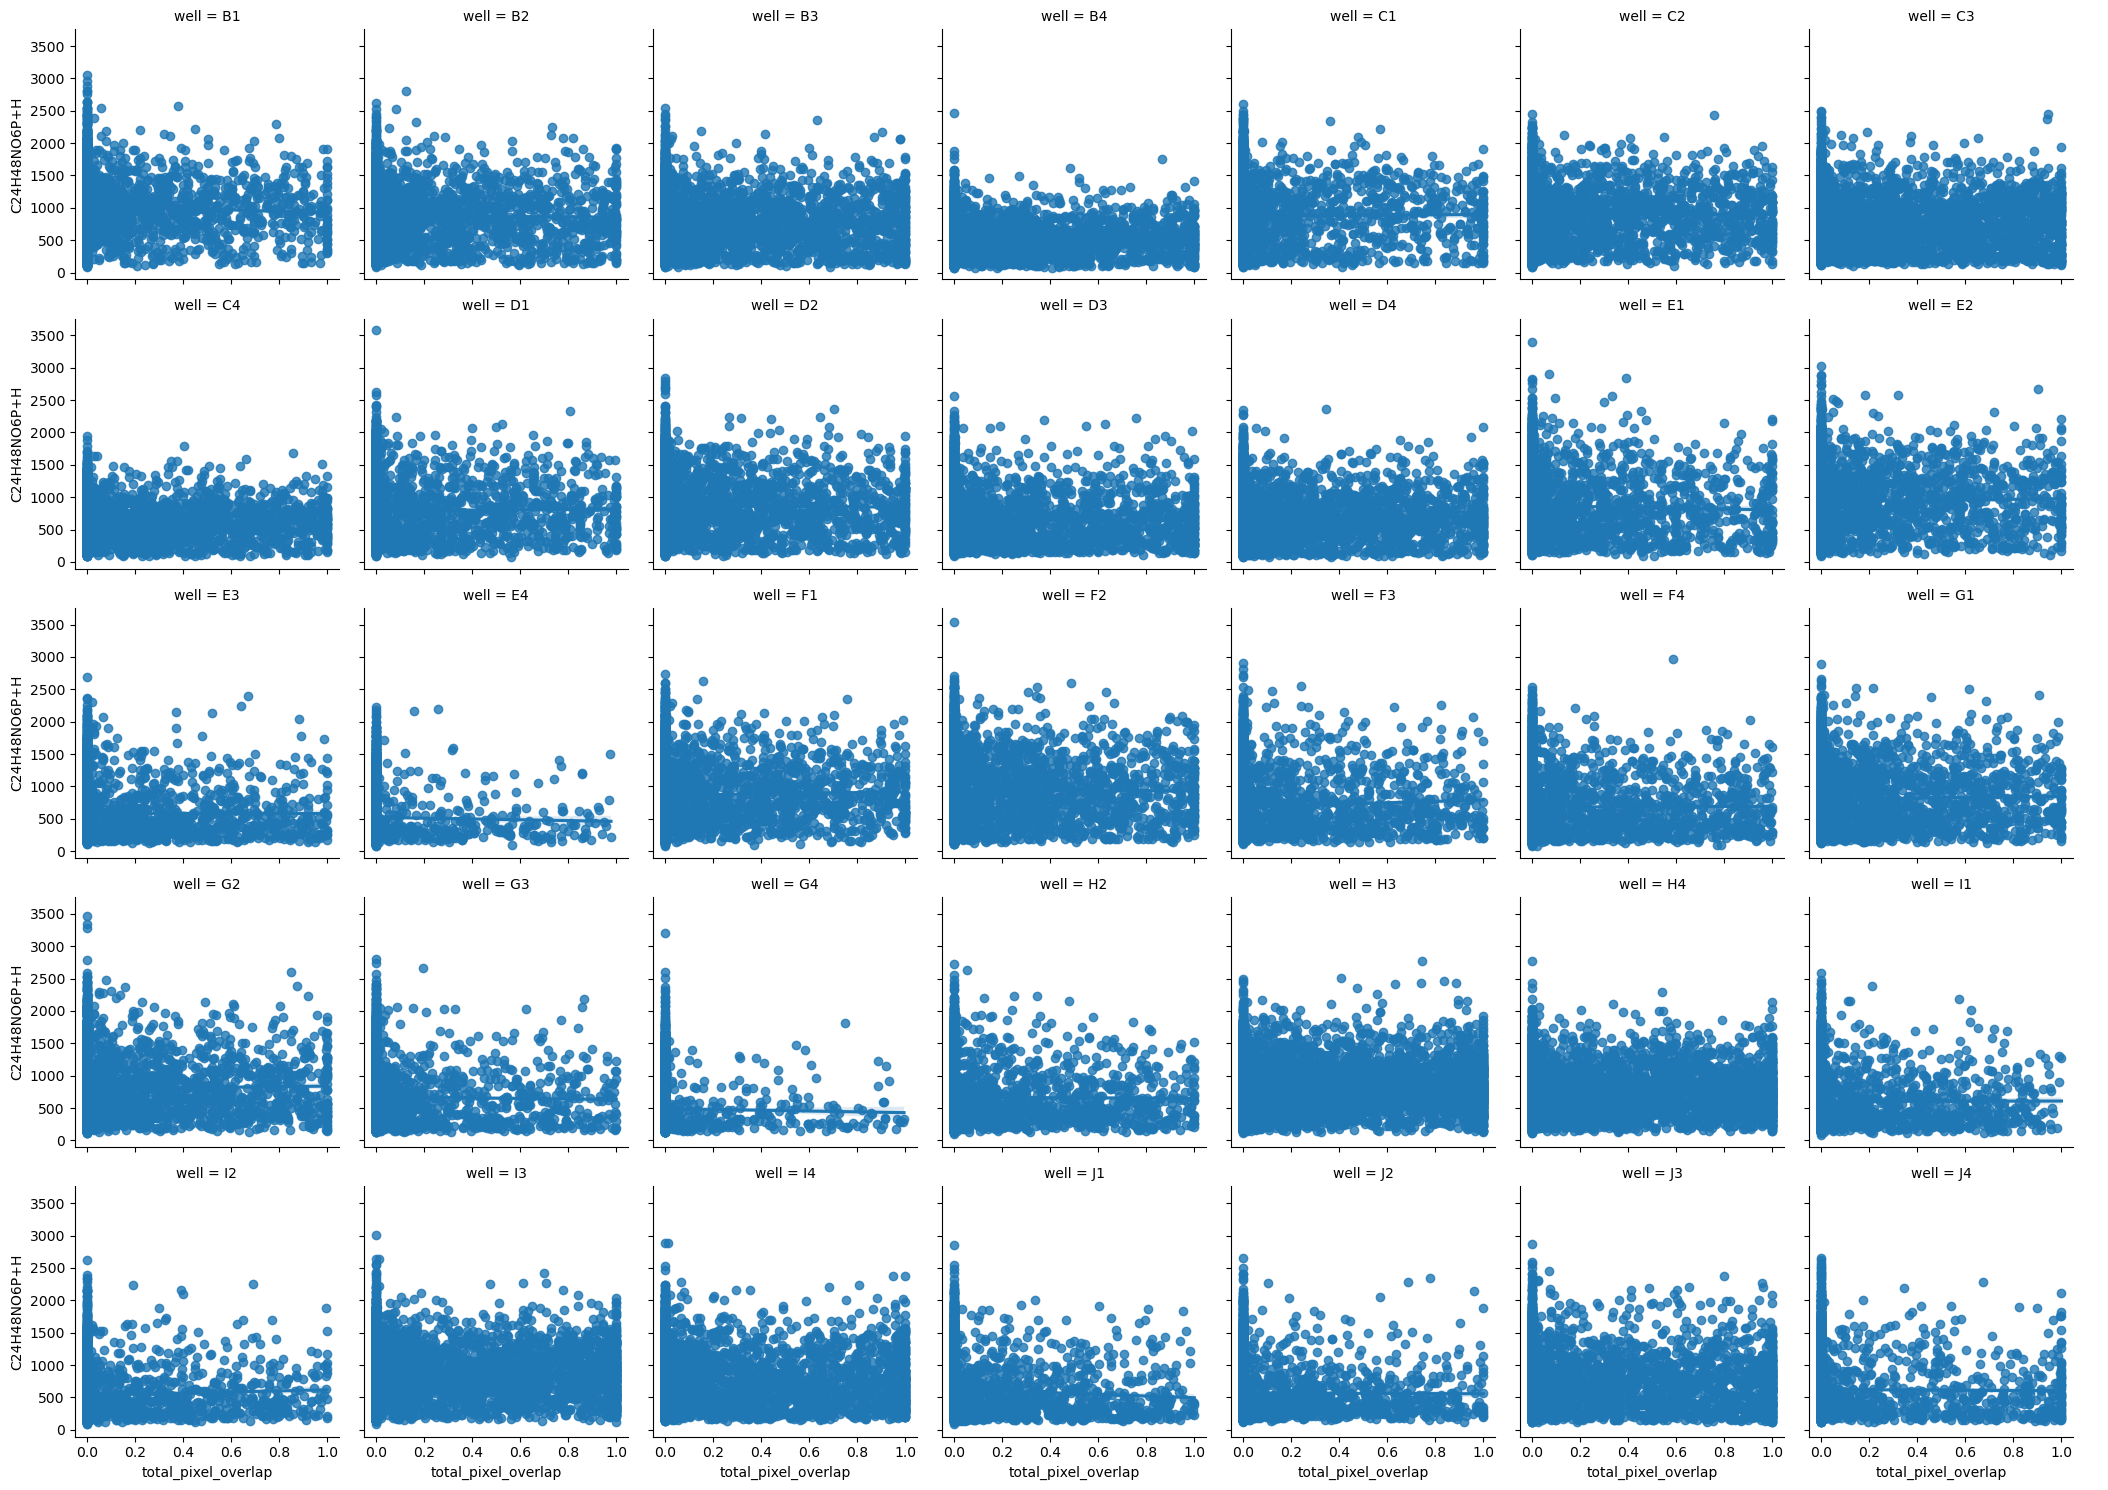

In [9]:
am_adata.obs['total_pixel_overlap'] = am_adata_cor.obs['total_pixel_overlap']
plot_all_wells(am_adata)

Intercept               -0.662195
total_pixel_overlap    628.571440
dtype: float64


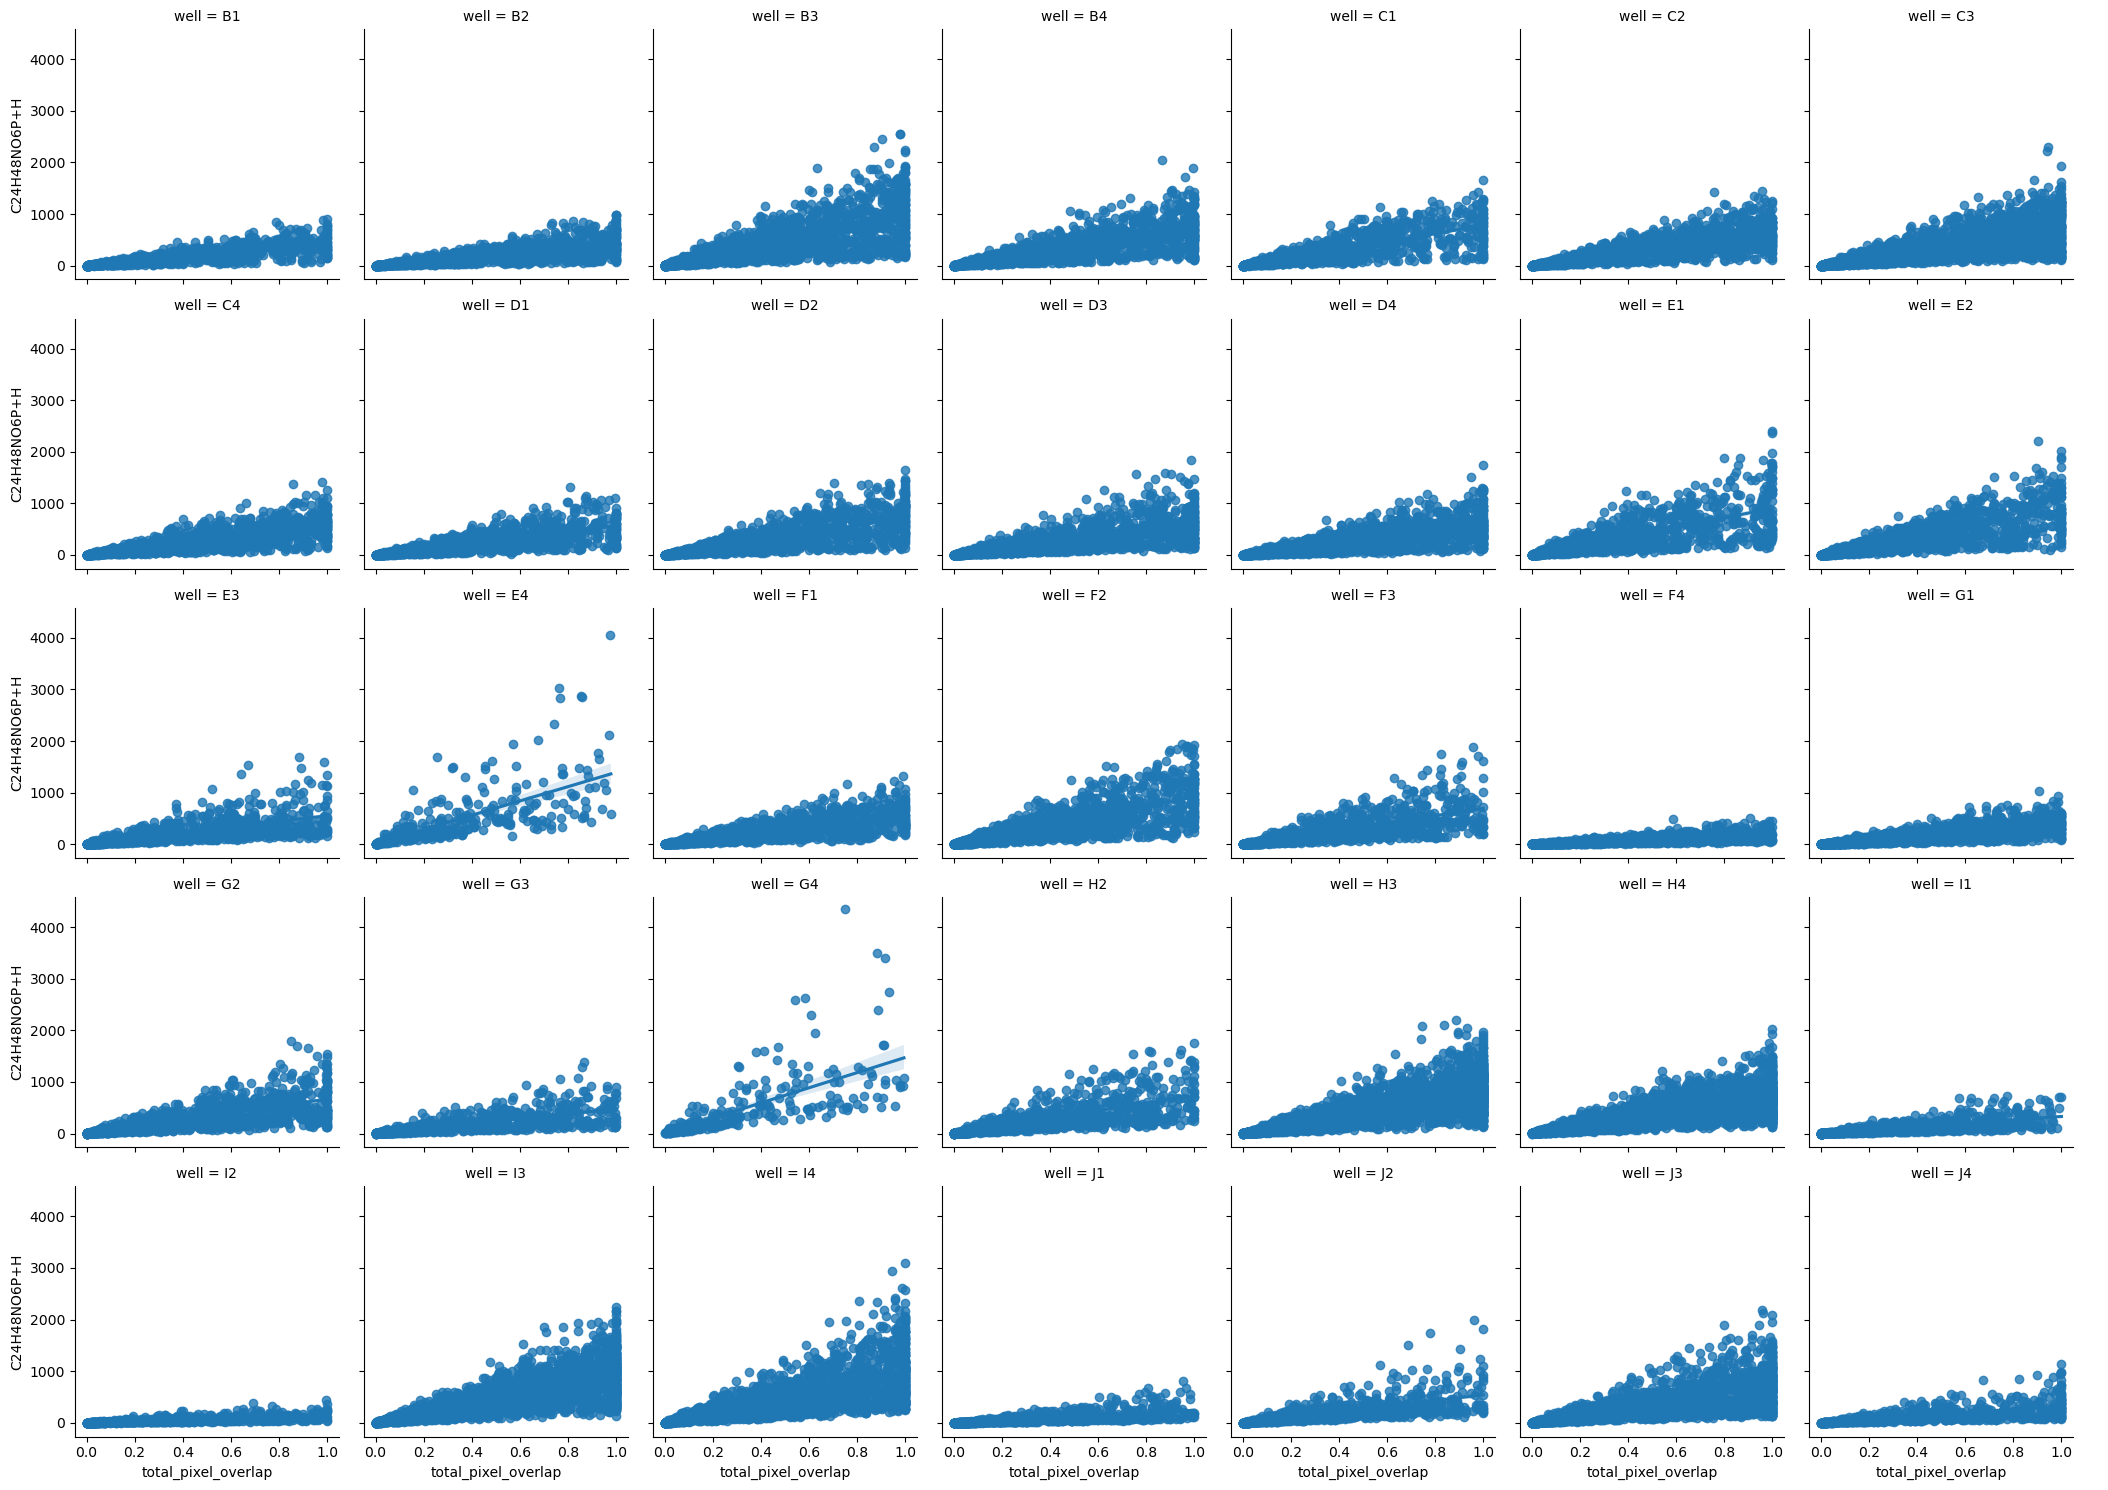

In [10]:
plot_all_wells(am_adata_cor)

The plots above are based on the total_pixel_overlap measure, as computed within the correction procedure. The anndata object provided by SpaceM already contain a measure called am_sampling_ratio, which should have the same meaning as the computed total_pixel_overlap. However, the two measures do not correlate at all. Consequently, the corrected ion intensity data does not show a dependency on am_sampling_ratio (see below).

Intercept              0.327442
total_pixel_overlap    0.076184
dtype: float64


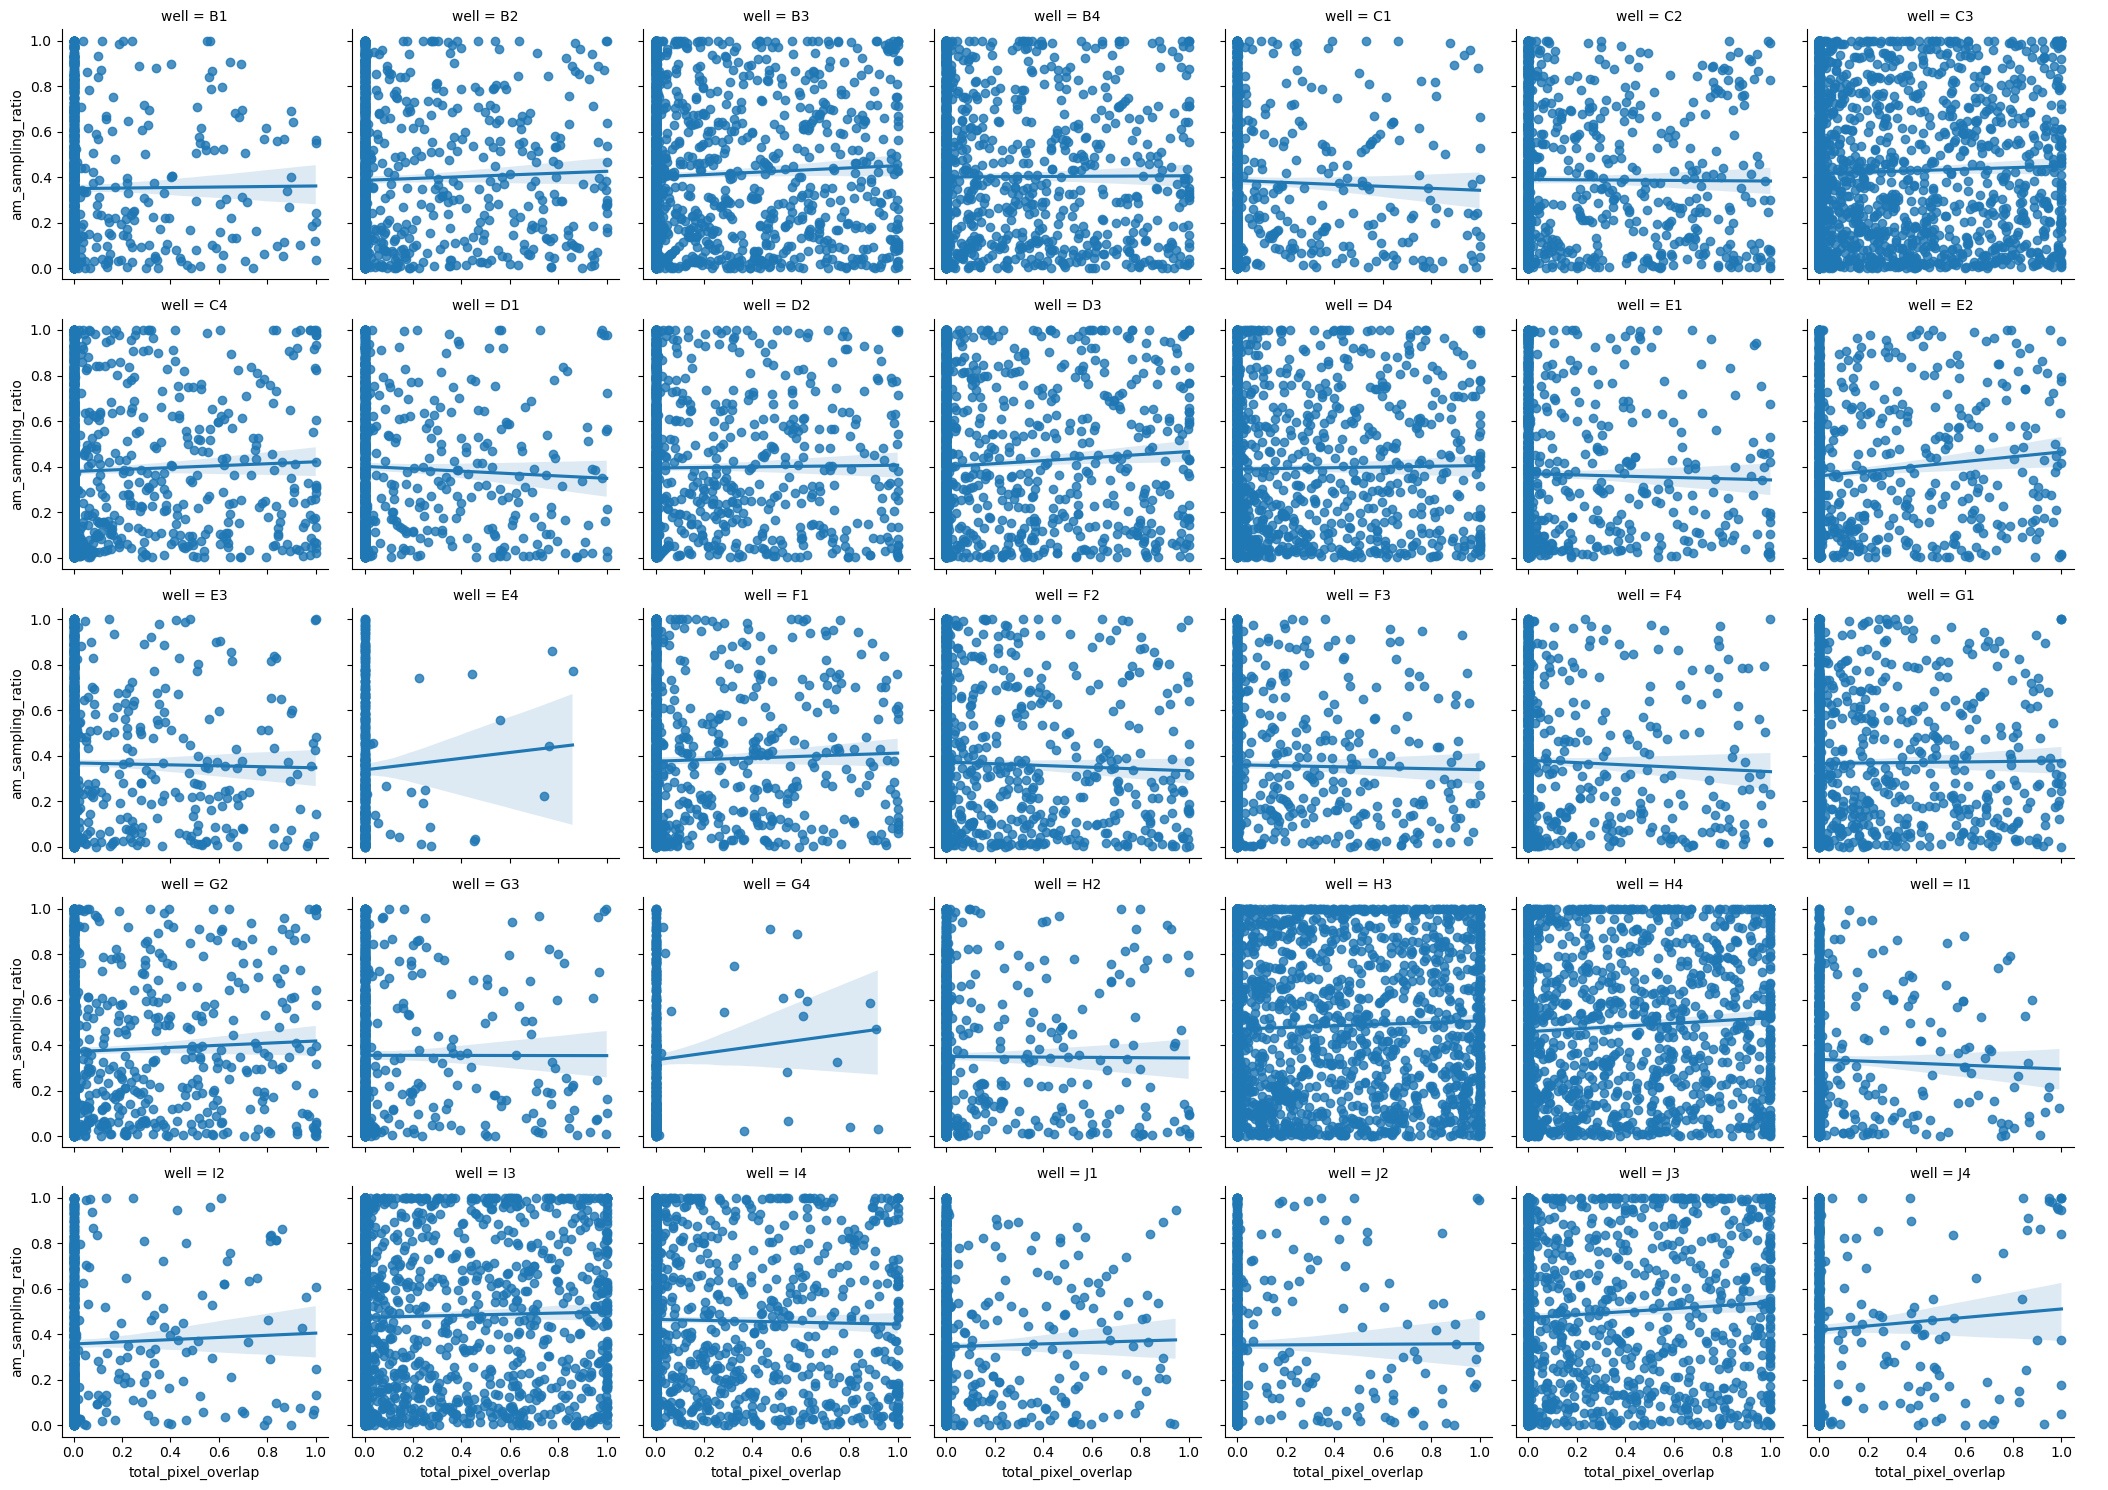

In [11]:
plot_all_wells(am_adata, ion = 'am_sampling_ratio')

Intercept            152.957008
am_sampling_ratio    136.412902
dtype: float64


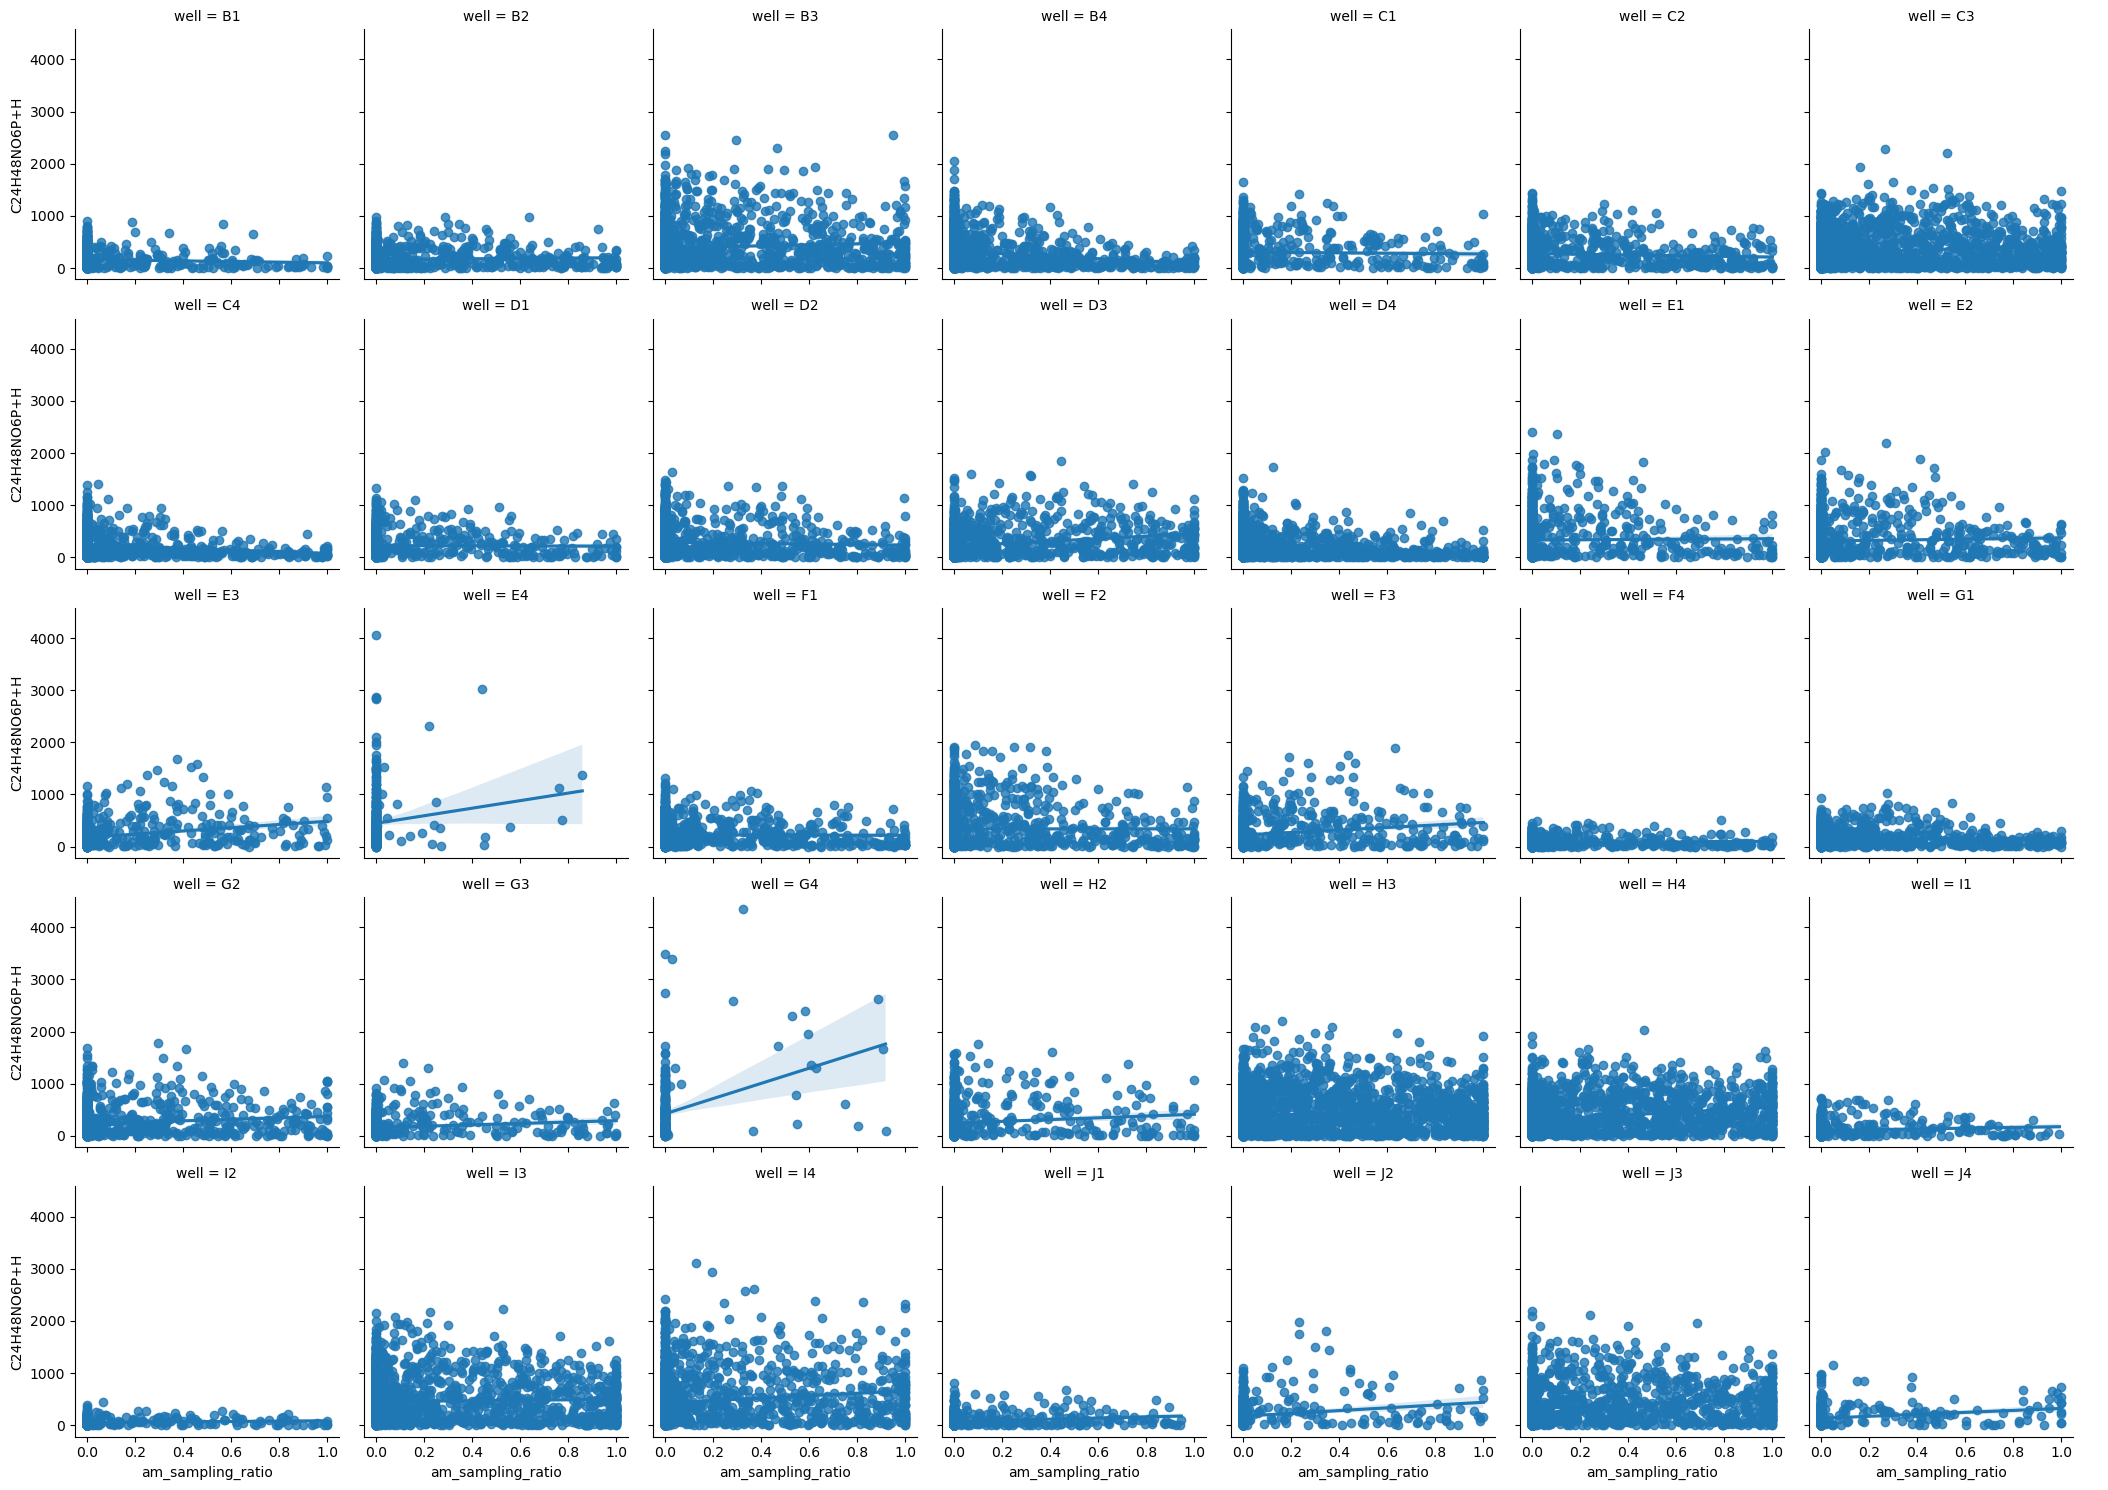

In [12]:
plot_all_wells(am_adata_cor, x = 'am_sampling_ratio')

Intercept    834.720567
cell_area      0.025790
dtype: float64


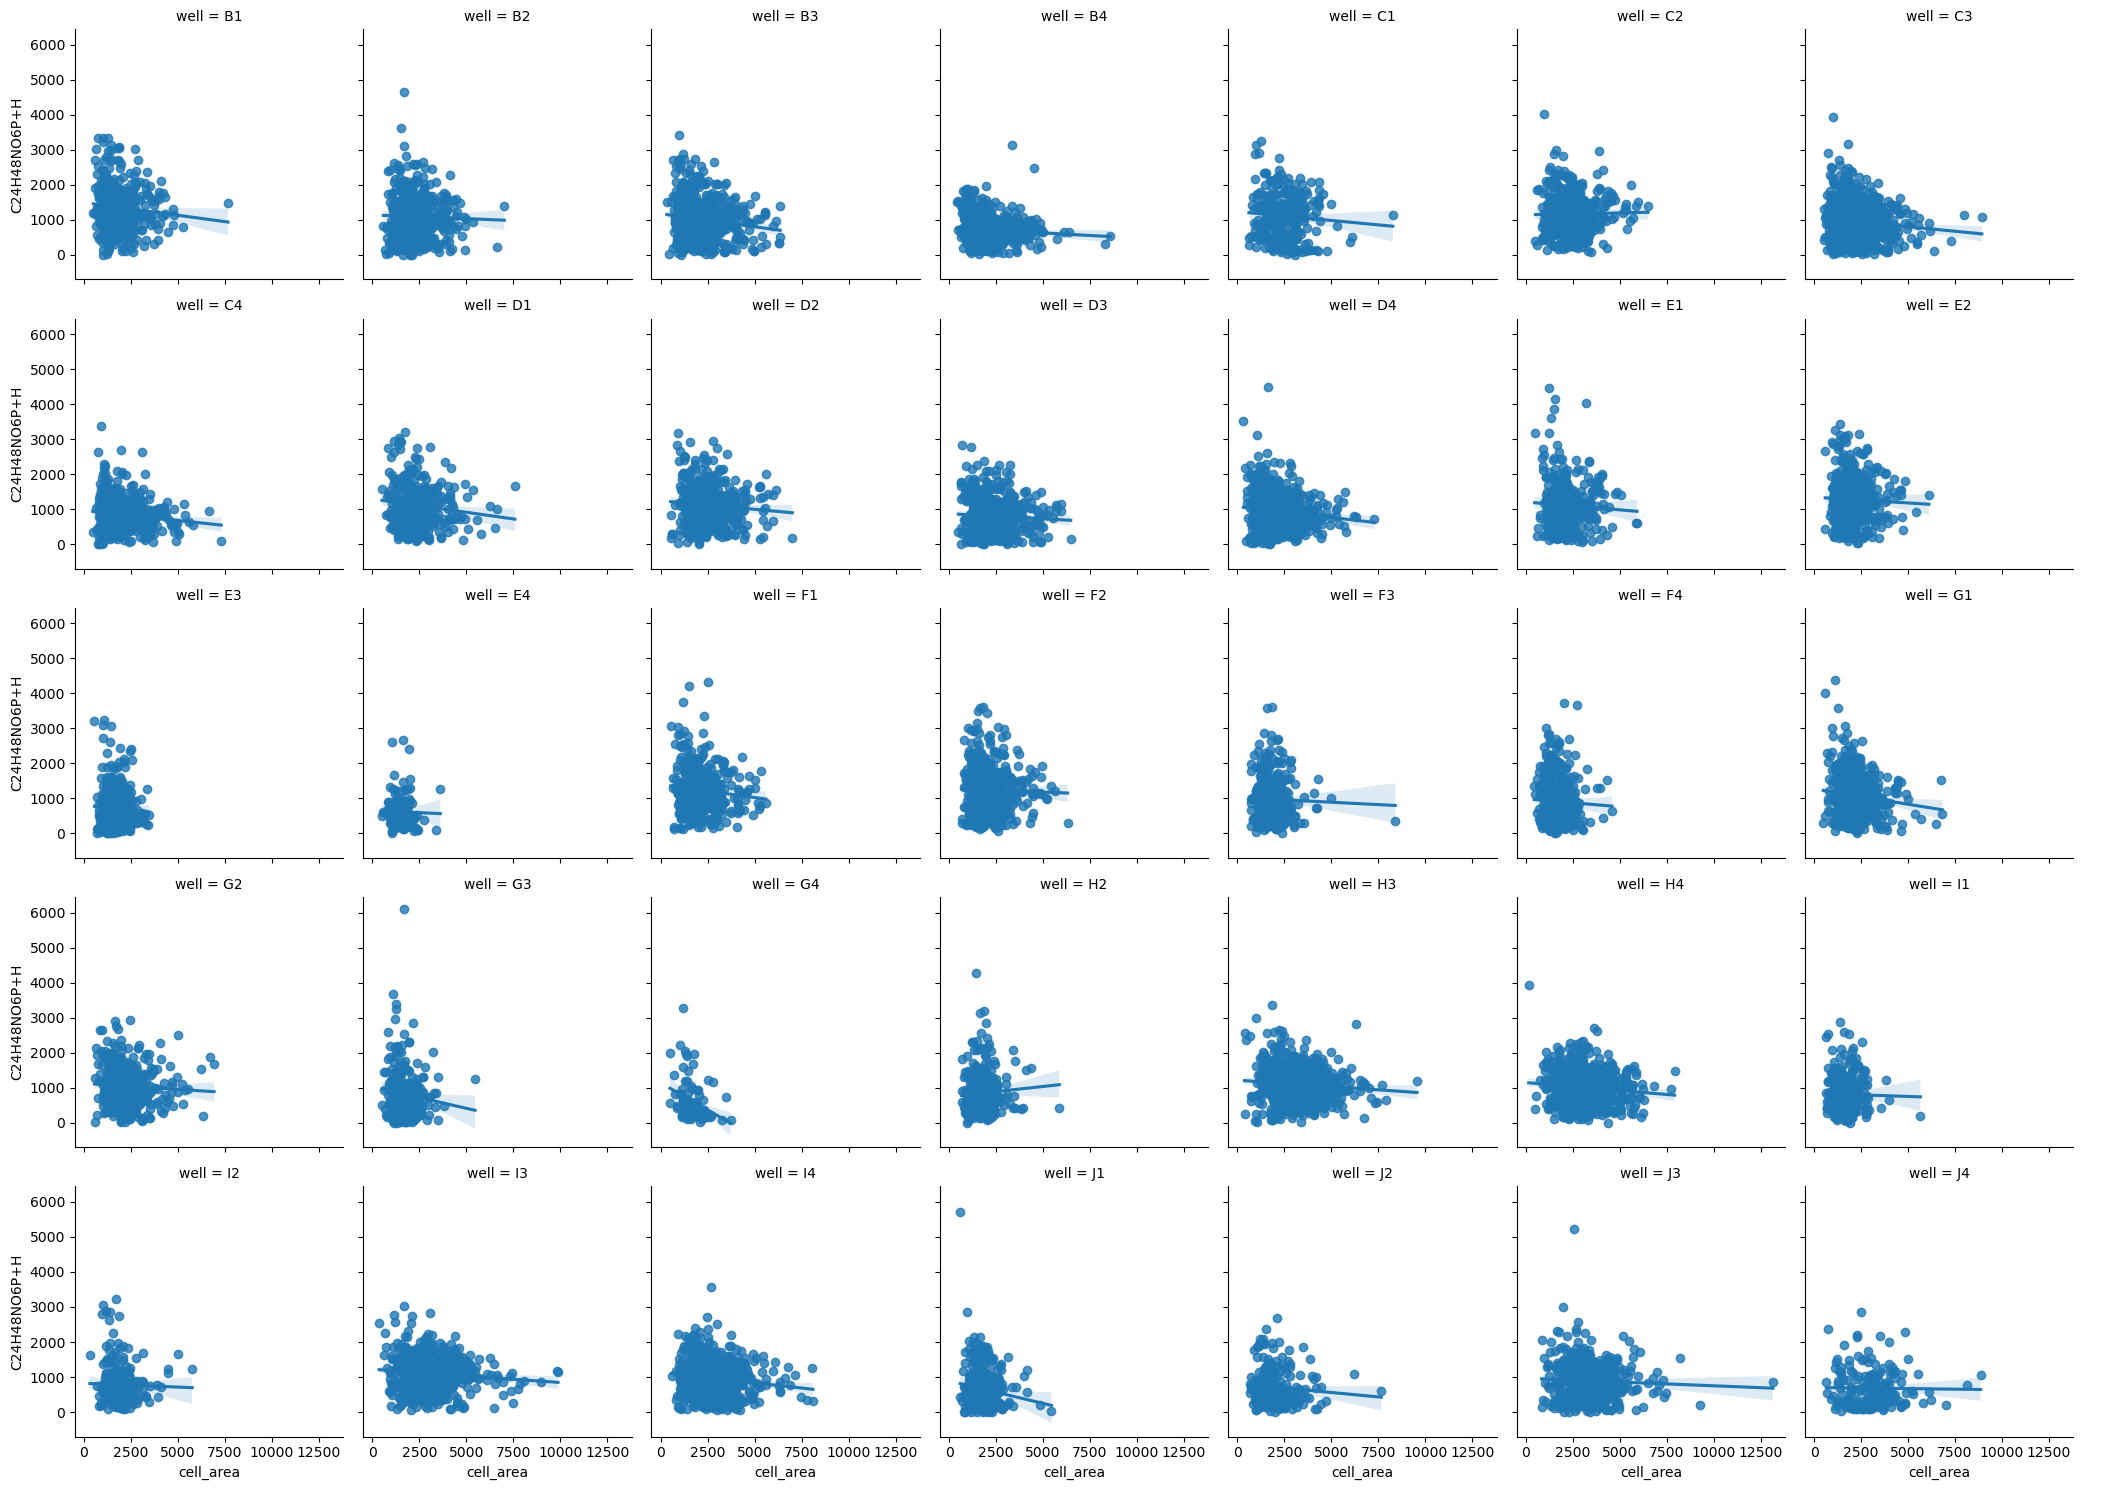

In [13]:
plot_all_wells(adata_cor, x = 'cell_area')